In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose


In [18]:
# Part 1: Data Preparation and Exploration
# 1. Data Loading
df = pd.read_csv('/content/exchange_rate.csv')
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')
df.set_index('date', inplace=True)
df.dropna(inplace=True)


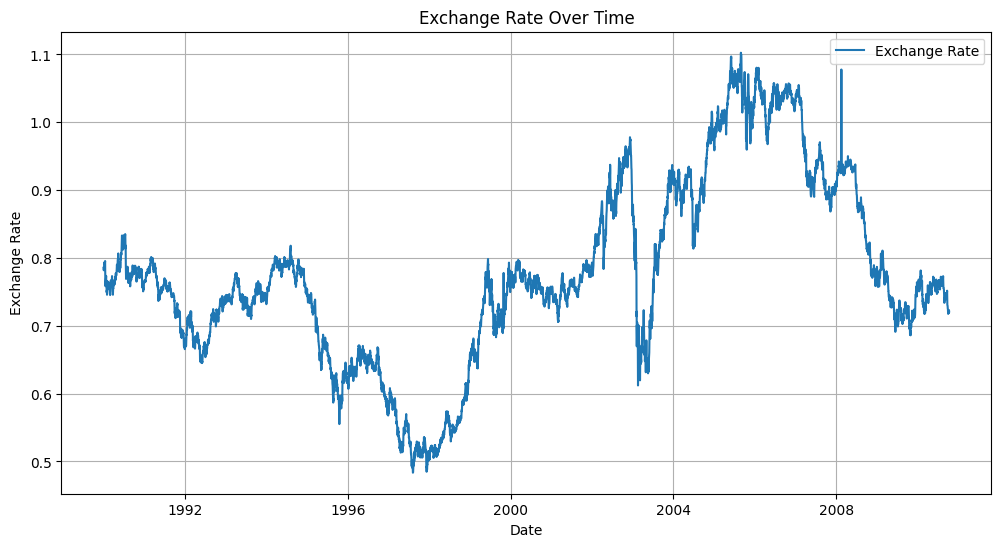

In [19]:
# 2. Initial Exploration
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Ex_rate'], label='Exchange Rate')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()


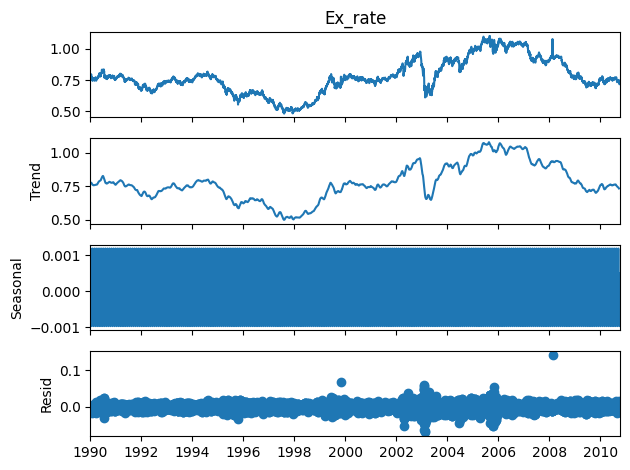

In [20]:
# Seasonal Decomposition
decomposition = seasonal_decompose(df['Ex_rate'], model='additive', period=30)
decomposition.plot()
plt.show()


In [21]:
# 3. Data Preprocessing
# Handle outliers (e.g., using Z-score)
from scipy.stats import zscore
df['Z_score'] = zscore(df['Ex_rate'])
df = df[(df['Z_score'].abs() < 3)]  # Remove outliers
df.drop(columns=['Z_score'], inplace=True)

<Figure size 1200x600 with 0 Axes>

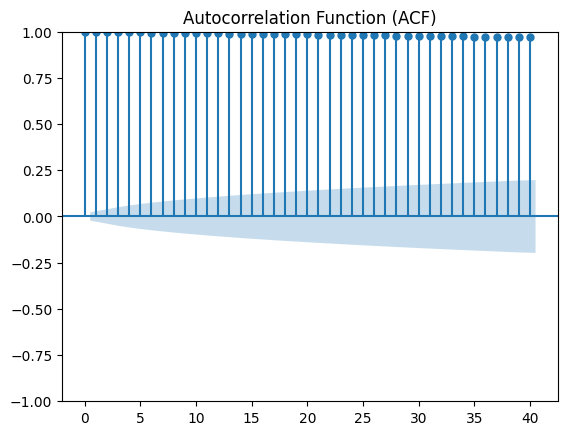

<Figure size 1200x600 with 0 Axes>

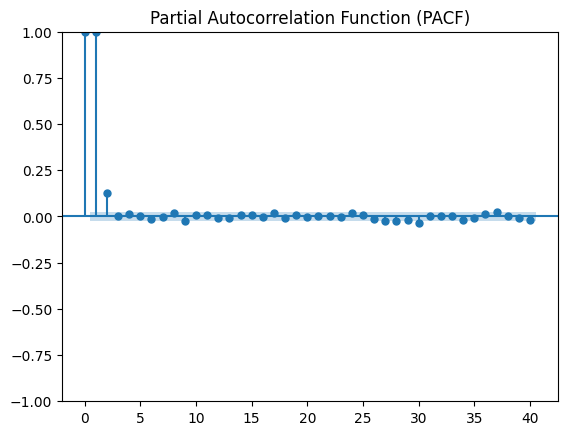

In [23]:
# Part 2: Model Building - ARIMA
# 1. Parameter Selection for ARIMA
plt.figure(figsize=(12, 6))
plot_acf(df['Ex_rate'], lags=40, title='Autocorrelation Function (ACF)')
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(df['Ex_rate'], lags=40, title='Partial Autocorrelation Function (PACF)')
plt.show()


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Sat, 15 Feb 2025   AIC                         -56102.322
Time:                        18:45:37   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

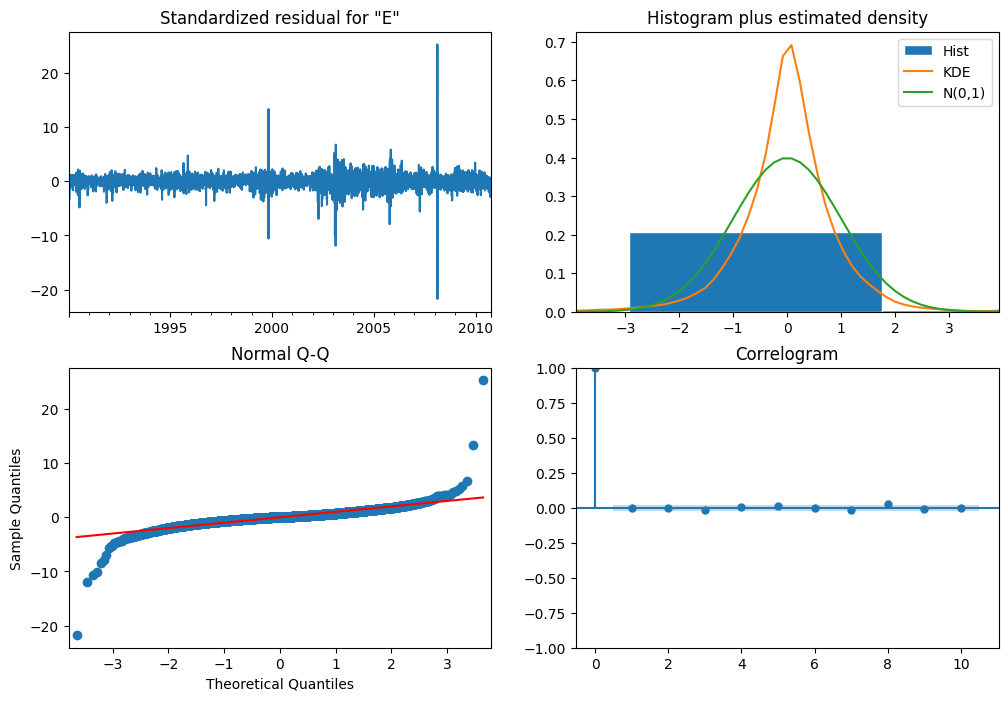

In [24]:
# 2. Model Fitting
p, d, q = 1, 1, 1  # Based on ACF/PACF
arima_model = ARIMA(df['Ex_rate'], order=(p, d, q))
arima_results = arima_model.fit()
print(arima_results.summary())

# 3. Diagnostics
arima_results.plot_diagnostics(figsize=(12, 8))
plt.show()

In [25]:

# 4. Forecasting
forecast_steps = 30
arima_forecast = arima_results.get_forecast(steps=forecast_steps)
arima_forecast_mean = arima_forecast.predicted_mean
arima_confidence_intervals = arima_forecast.conf_int()

# Part 3: Model Building - Exponential Smoothing
# 1. Model Selection
# Holt-Winters is chosen due to observed seasonality and trend
exp_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal='add', seasonal_periods=30)



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [26]:
# 2. Parameter Optimization (example using AIC)
best_aic = np.inf
best_params = None
for trend in ['add', 'mul']:
    for seasonal in ['add', 'mul']:
        model = ExponentialSmoothing(df['Ex_rate'], trend=trend, seasonal=seasonal, seasonal_periods=30)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_params = (trend, seasonal)

print(f"Best Parameters: Trend={best_params[0]}, Seasonal={best_params[1]}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/sta

Best Parameters: Trend=mul, Seasonal=mul


In [27]:
# 3. Model Fitting and Forecasting
exp_model = ExponentialSmoothing(df['Ex_rate'], trend=best_params[0], seasonal=best_params[1], seasonal_periods=30)
exp_results = exp_model.fit()
exp_forecast = exp_results.forecast(steps=forecast_steps)



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [28]:
# Part 4: Evaluation and Comparison
# 1. Compute Error Metrics
def calculate_metrics(actual, forecast):
    mae = mean_absolute_error(actual, forecast)
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100
    return mae, rmse, mape

train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [29]:

# ARIMA
arima_train_model = ARIMA(train['Ex_rate'], order=(p, d, q))
arima_train_results = arima_train_model.fit()
arima_train_forecast = arima_train_results.get_forecast(steps=len(test))
arima_train_forecast_mean = arima_train_forecast.predicted_mean


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [30]:

# Exponential Smoothing
exp_train_model = ExponentialSmoothing(train['Ex_rate'], trend=best_params[0], seasonal=best_params[1], seasonal_periods=30)
exp_train_results = exp_train_model.fit()
exp_train_forecast = exp_train_results.forecast(steps=len(test))



/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [31]:
# Calculate metrics
arima_mae, arima_rmse, arima_mape = calculate_metrics(test['Ex_rate'], arima_train_forecast_mean)
exp_mae, exp_rmse, exp_mape = calculate_metrics(test['Ex_rate'], exp_train_forecast)

print("ARIMA Metrics:")
print(f"MAE: {arima_mae}, RMSE: {arima_rmse}, MAPE: {arima_mape}")

print("Exponential Smoothing Metrics:")
print(f"MAE: {exp_mae}, RMSE: {exp_rmse}, MAPE: {exp_mape}")


ARIMA Metrics:
MAE: 0.17770970449121345, RMSE: 0.2054366965966928, MAPE: 22.797966173811552
Exponential Smoothing Metrics:
MAE: 0.2077384418278544, RMSE: 0.24044843692338072, MAPE: 26.655651383359185


In [32]:

# 2. Model Comparison
if arima_mae < exp_mae:
    print("ARIMA performs better based on MAE.")
else:
    print("Exponential Smoothing performs better based on MAE.")


ARIMA performs better based on MAE.


In [33]:


# 3. Conclusion
print("ARIMA is better for capturing linear trends, while Exponential Smoothing is better for seasonal patterns.")

ARIMA is better for capturing linear trends, while Exponential Smoothing is better for seasonal patterns.
